#### 3

In [1]:
library(forecast)
library(ggplot2)
library(dplyr)
library(gridExtra)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘gridExtra’

The following object is masked from ‘package:dplyr’:

    combine



In [2]:
# library(doParallel)
library(doMC)
options(cores = 10)
registerDoMC()
require(svMisc)

Loading required package: foreach
Loading required package: iterators
Loading required package: parallel
Loading required package: svMisc

Attaching package: ‘svMisc’

The following object is masked from ‘package:utils’:

    ?



In [3]:
library(data.table)
library(hts)  


Attaching package: ‘data.table’

The following objects are masked from ‘package:dplyr’:

    between, first, last



In [4]:
df_eu  <-  read.csv(file="../data_hts/hts_us_ind_filled.csv", header=TRUE, sep=",", row.names =1 )
df_eu  <-  df_eu/1000
var_freq  <- 4    
var_start_year  <- 2005   
gdp_agg <- df_eu_sums <-  rowSums(df_eu)
gdp_agg  <- ts(gdp_agg, frequency = var_freq, start = var_start_year) 

In [5]:
var_h  <- 8
var_window  <-  28 - 1
var_topup  <-  2
var_iter   <- (length(gdp_agg)+var_topup)/var_freq-(var_window+1)/var_freq-2

In [6]:
# var_allornot  <- var_freq
var_allornot  <- 1
# var_shift  <-  var_topup
var_shift  <-  0

var_arpdq   <-  c(4,0,0)
var_sarpdq   <-  c(0,0,0)
var_drift   <-  FALSE
var_constant   <-  TRUE
var_char  <-  c(2,3)

In [7]:
df_eu  <-  as.data.table(df_eu)
data  <-  df_eu
y  <-  hts(data, characters = var_char)
s  <-  smatrix(y)
var_countries  <-  dim(read.csv(file="../clustering/hts_us_ind_filled_state.csv", header=TRUE, sep=",", row.names =1 ))[2]+1
this_file_models_list  <-  list()
this_model_list  <-  list()



In [8]:
l <- ac <- m_top  <- l_test  <-  l_top  <-  list()

df_ac  <-  data.frame(matrix(ncol = 0, nrow = 0))

k  <- 0

for (i in 0:(var_iter*var_allornot - var_shift)){
    k  <-  k+1
    st_year  <-  var_start_year + i/var_allornot
    train_start  <- st_year 
    train_end  <- st_year + 1/var_freq*(var_window)
    test_start  <- st_year + 1/var_freq*(var_window+1) 
    test_end  <-  st_year + 1/var_freq*(var_window+var_h)
    
    dates  <-  (c(train_start, train_end, test_start, test_end, train_start-var_topup/var_freq, train_end-var_topup/var_freq, test_start-var_topup/var_freq)-var_start_year)*var_freq+1
    
    train_start  <- dates[1] 
    train_end  <- dates[2]
    test_start  <- dates[3]
    test_end  <- dates[4]
    
    print(c(train_start, train_end, test_start, test_end))
    
    
    if (i == 0){
        gts_train <- window(y, end=train_end)    
    }
    else{
        if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
            gts_train <- window(y, start=dates[5], end=dates[6])
        }else{
            gts_train <- window(y, start=train_start, end=train_end)
    }}
    
    if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
        gts_test <- window(y, start=dates[7])
      
    }else{  
     gts_test <- window(y, start=test_start, end=test_end)
          
    }
    
    allts <- aggts(gts_train)
    
    t <- train_start:train_end
    regressors <- cbind(trend=t,quad=t^2)
    
    
    ms <-  foreach(j=1:ncol(allts)) %dopar% {
        model  <- tryCatch(        
        Arima(msts(allts[,j], seasonal.periods = var_freq), order=var_arpdq, seasonal=var_sarpdq,  include.drift = var_drift, include.mean = var_constant, xreg = regressors, method="ML"), 
            error = function(e) 
#                               {tryCatch( 
                Arima(msts(allts[,j], seasonal.periods = var_freq), order=var_arpdq, seasonal=var_sarpdq, include.drift = var_drift, include.mean = var_constant, xreg = regressors, method="CSS") #,
#                          error = function(e)              
#                             auto.arima(msts(allts[,j], seasonal.periods = var_freq))
#                          )}
                        
            )
        
    }
    
     
        
    allf <- matrix(, nrow=var_h, ncol=ncol(allts))
        
    t_f <- test_start:test_end
    regressors_f <- cbind(trend=t_f,quad=t_f^2) 
    
    
    
    for(j in 1:ncol(allts)){  
    allf[,j] <- forecast(ms[[j]], h=var_h, xreg = regressors_f)$mean
    
    
    }



    allf <- ts(allf)
    colnames(allf)  <-  colnames(allts)  
    g <- get_nodes(gts_train)
    y.f <- combinef(allf, nodes = g, weights = c(rep(0, var_countries), rep(1, (ncol(allts)-var_countries) )))
    forecasts_7  <- y.f[[1]]
    colnames(forecasts_7)  <- colnames(y[[1]])
    data_f5  <- rbind(gts_train[[1]], forecasts_7)
    y_f5  <- hts(data_f5, characters = var_char)
    gts_forecasts_7 <- window(y_f5, start=dim(y_f5[[1]])[1]-var_h+1)
    this_model_list[[k]]  <- ms
    l[[k]]  <- allts(gts_forecasts_7)
    ac[[k]]  <-  accuracy.gts(gts_forecasts_7, gts_test)[, 1] 
    progress(i, progress.bar = TRUE)     
    }



[1]  1 28 29 36
          0%---------25%---------50%---------75%--------100%
Progress: [1]  5 32 33 40
[1]  9 36 37 44
|[1] 13 40 41 48
|[1] 17 44 45 52
[1] 21 48 49 56


In [9]:
var_acc_metrics  <-  c(1,2,4)
df_acc_test  <- ac[[1]][var_acc_metrics]
for (i in ac[2:length(ac)]){
    x  <-  i[var_acc_metrics]
    df_acc_test   <-  cbind(df_acc_test, x)
}
df_acc_test  <- t(df_acc_test)
df_acc_test  <-  as.data.frame(df_acc_test)
row.names(df_acc_test)  <-  seq(1,length(ac))
df_acc  <- df_acc_test
df_acc  <-  cbind(df_acc, seq(1, length(ac)))
colnames(df_acc)[length(var_acc_metrics)+1]  <-  'Iteration'

In [10]:
df_acc$Iteration  <-  df_acc$Iteration*var_freq-(var_freq-1)

In [11]:
df_acc$Iteration[length(df_acc$Iteration)]  <-   df_acc$Iteration[length(df_acc$Iteration)] - var_topup

In [12]:
this_file_models_list[[1]]  <-  this_model_list


In [13]:
l[[5]][,1]

Time Series:
Start = 29 
End = 36 
Frequency = 1 
[1] 17233.23 17320.70 17442.92 17578.80 17705.65 17834.69 17957.81 18077.01

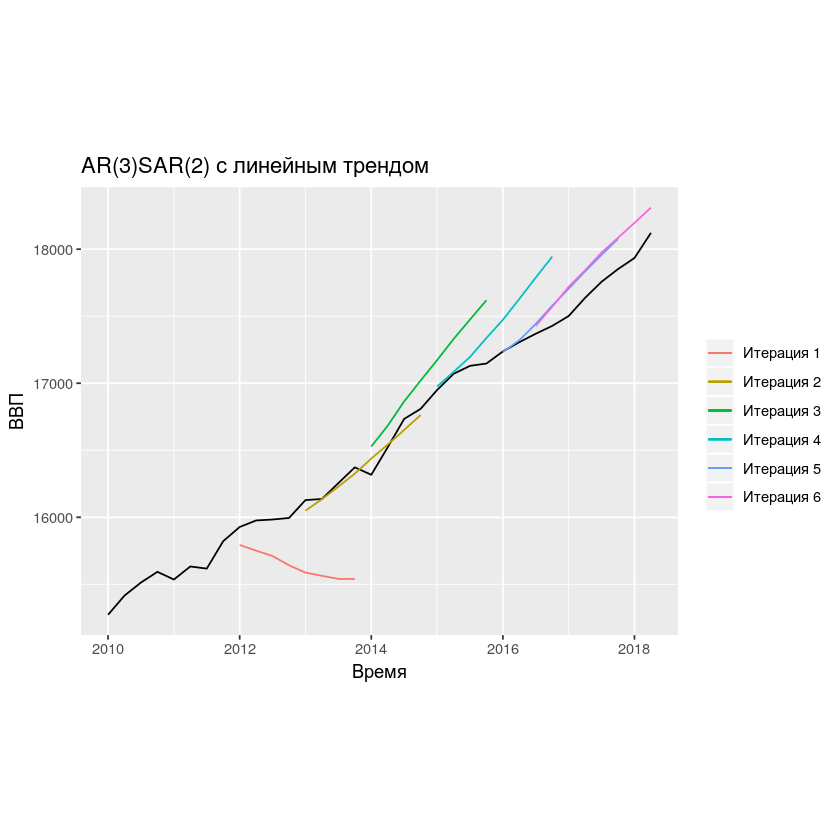

In [14]:
plot_forecasts  <-  autoplot(window(gdp_agg, start=2010))+
    xlab("Время") + ylab('ВВП') +
    ggtitle("AR(3)SAR(2) с линейным трендом") +
    guides(colour=guide_legend(title=" ")) +
    theme(aspect.ratio = 0.75)

# for (i in 0:(var_iter*var_allornot - var_shift)){
#     k  <-  k+1
#     st_year  <-  var_start_year + i/var_allornot
#     train_start  <- st_year 
#     train_end  <- st_year + 1/var_freq*(var_window)
#     test_start  <- st_year + 1/var_freq*(var_window+1) 
#     test_end  <-  st_year + 1/var_freq*(var_window+var_h)
    
#     dates  <-  (c(train_start, train_end, test_start, test_end, train_start-var_topup/var_freq, train_end-var_topup/var_freq, test_start-var_topup/var_freq)-var_start_year)*var_freq+1

    

for (i in 1:length(l)){
    if (i!=length(l)){
    plot_forecasts  <-  plot_forecasts  + 
    autolayer(msts(l[[i]][,1], seasonal.periods = var_freq, start=var_start_year + i/var_allornot+1/var_freq*(var_window+1)-1), series=paste("Итерация" , i, sep=" ") ) 
    }else{
            plot_forecasts  <-  plot_forecasts  + 
    autolayer(msts(l[[i]][,1], seasonal.periods = var_freq, start=var_start_year + i/var_allornot+1/var_freq*(var_window+1)-1-var_topup/var_freq), series=paste("Итерация" , i, sep=" ") ) 

        
    }
}

plot_forecasts


In [15]:
df_acc

ME,RMSE,MAPE,Iteration
455.89321,511.55672,2.8196720,1
17.58998,64.19862,0.3213733,5
-251.66349,271.86424,1.4883765,9
-223.90859,283.69825,1.2930799,13
-132.65163,158.04327,0.7584714,17
-190.98365,200.04001,1.0762169,19


In [16]:
colMeans(df_acc)

ME       RMSE       MAPE  Iteration 
-54.287363 248.233516   1.292865  10.666667

In [17]:
df_mean_acc <- readRDS("df_mean_acc_noweights.rds")

rownames(df_mean_acc)[2:5]  <-  c('3 level', '2 level (state)', '2 level (type)' ,'2 level (clusetered)' )
df_mean_acc

,Квартальные,Сезонно сглаженные,Месячные
1 level,88.92257,242.1291,9146.793
3 level,96.77646,242.5226,10496.554
2 level (state),102.22984,242.5226,10507.589
2 level (type),92.26188,241.7866,9970.511
2 level (clusetered),97.38575,241.0673,10387.388


In [18]:
df_mean_acc[2,2]  <-  colMeans(df_acc)[[2]] 
df_mean_acc

,Квартальные,Сезонно сглаженные,Месячные
1 level,88.92257,242.1291,9146.793
3 level,96.77646,248.2335,10496.554
2 level (state),102.22984,242.5226,10507.589
2 level (type),92.26188,241.7866,9970.511
2 level (clusetered),97.38575,241.0673,10387.388


In [19]:
df_acc

ME,RMSE,MAPE,Iteration
455.89321,511.55672,2.8196720,1
17.58998,64.19862,0.3213733,5
-251.66349,271.86424,1.4883765,9
-223.90859,283.69825,1.2930799,13
-132.65163,158.04327,0.7584714,17
-190.98365,200.04001,1.0762169,19


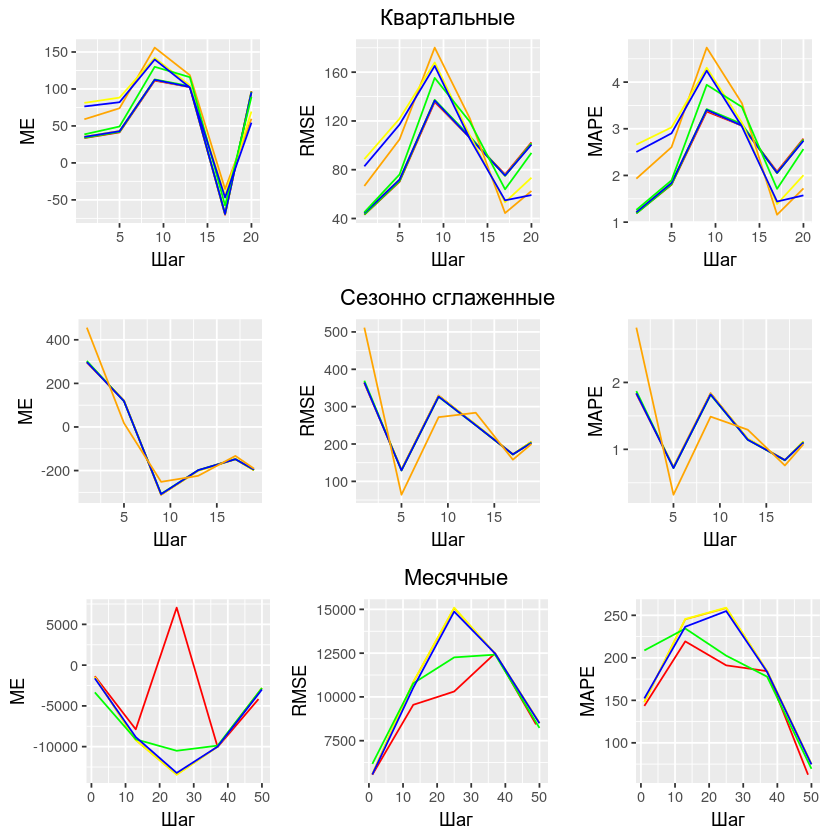

In [20]:
# Basic line plot with points

plots_test_all <- readRDS("plots_test_not_all_noweights.rds")

var_col_test  <-  'orange'
# var_col_train  <-  'red'

for (i in 1:3) {
    
    k = i + 3
    
    if  (i==1) {
        
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=ME), colour = var_col_test, data =  df_acc) 
    
        } else if (i==2) { 
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=RMSE), colour = var_col_test, data =  df_acc) 
        } else if (i==3)  {
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=MAPE), colour = var_col_test, data =  df_acc) 
 
    }        
    }

grid.arrange(grobs = plots_test_all, ncol = 3)

#### 2 state

In [21]:
df_eu  <-  read.csv(file="../clustering/hts_us_ind_filled_state.csv", header=TRUE, sep=",", row.names =1 )
df_eu  <-  df_eu/1000


In [22]:
# var_allornot  <- var_freq
var_allornot  <- 1
# var_shift  <-  var_topup
var_shift  <-  0

In [23]:
df_eu  <-  as.data.table(df_eu)
data  <-  df_eu
y  <-  hts(data)
s  <-  smatrix(y)
# gts_train  <- window(y, start=20, end=67)
# gts_test  <- window(y, start=68, end=75)
allts <- aggts(y)
allf <- matrix(, nrow=var_h, ncol=ncol(allts))

Since argument characters are not specified, the default labelling system is used.


In [24]:
l <- ac <- m_top  <- l_test  <-  l_top  <-  list()

df_ac  <-  data.frame(matrix(ncol = 0, nrow = 0))

k  <- 0

for (i in 0:(var_iter*var_allornot - var_shift)){
    k  <-  k+1
    st_year  <-  var_start_year + i/var_allornot
    train_start  <- st_year 
    train_end  <- st_year + 1/var_freq*(var_window)
    test_start  <- st_year + 1/var_freq*(var_window+1) 
    test_end  <-  st_year + 1/var_freq*(var_window+var_h)
    
    dates  <-  (c(train_start, train_end, test_start, test_end, train_start-var_topup/var_freq, train_end-var_topup/var_freq, test_start-var_topup/var_freq)-var_start_year)*var_freq+1
    
    train_start  <- dates[1] 
    train_end  <- dates[2]
    test_start  <- dates[3]
    test_end  <- dates[4]
    
    print(c(train_start, train_end, test_start, test_end))
    
    
    if (i == 0){
        gts_train <- window(y, end=train_end)    
    }
    else{
        if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
            gts_train <- window(y, start=dates[5], end=dates[6])
        }else{
            gts_train <- window(y, start=train_start, end=train_end)
    }}
    
    if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
        gts_test <- window(y, start=dates[7])
      
    }else{  
     gts_test <- window(y, start=test_start, end=test_end)
          
    }
    
        
    allts <- aggts(gts_train)
    
    t <- train_start:train_end
    regressors <- cbind(trend=t,quad=t^2)
    
    
    ms <-  foreach(j=1:ncol(allts)) %dopar% {
        model  <- tryCatch(        
        Arima(msts(allts[,j], seasonal.periods = var_freq), order=var_arpdq, seasonal=var_sarpdq,  include.drift = var_drift, include.mean = var_constant, xreg = regressors, method="ML"), 
            error = function(e) 
#                               {tryCatch( 
                Arima(msts(allts[,j], seasonal.periods = var_freq), order=var_arpdq, seasonal=var_sarpdq, include.drift = var_drift, include.mean = var_constant, xreg = regressors,  method="CSS") #,
#                          error = function(e)              
#                             auto.arima(msts(allts[,j], seasonal.periods = var_freq))
#                          )}
                        
            )
        
    }
    
     
        
    allf <- matrix(, nrow=var_h, ncol=ncol(allts))
        
    t_f <- test_start:test_end
    regressors_f <- cbind(trend=t_f,quad=t_f^2) 
    
    
    
    for(j in 1:ncol(allts)){  
    allf[,j] <- forecast(ms[[j]], h=var_h, xreg = regressors_f)$mean
    
    
    }

    
    allf <- ts(allf)
    colnames(allf)  <-  colnames(allts)  
    g <- get_nodes(gts_train)
    y.f <- combinef(allf, nodes = g, weights = c(0,rep(1, dim(df_eu)[2])))
    forecasts_7  <- y.f[[1]]
    colnames(forecasts_7)  <- colnames(y[[1]])
    data_f5  <- rbind(gts_train[[1]], forecasts_7)
    y_f5  <- hts(data_f5)
    gts_forecasts_7 <- window(y_f5, start=dim(y_f5[[1]])[1]-var_h+1)
    this_model_list[[k]]  <- ms
    l[[k]]  <- allts(gts_forecasts_7)
    ac[[k]]  <-  accuracy.gts(gts_forecasts_7, gts_test)[, 1] 
    progress(i, progress.bar = TRUE)
    }



[1]  1 28 29 36


Since argument characters are not specified, the default labelling system is used.


          0%---------25%---------50%---------75%--------100%
Progress: [1]  5 32 33 40


Since argument characters are not specified, the default labelling system is used.


[1]  9 36 37 44


Since argument characters are not specified, the default labelling system is used.


|[1] 13 40 41 48


Since argument characters are not specified, the default labelling system is used.


|[1] 17 44 45 52


Since argument characters are not specified, the default labelling system is used.


[1] 21 48 49 56


Since argument characters are not specified, the default labelling system is used.


In [25]:
var_acc_metrics  <-  c(1,2,4)
df_acc_test  <- ac[[1]][var_acc_metrics]
for (i in ac[2:length(ac)]){
    x  <-  i[var_acc_metrics]
    df_acc_test   <-  cbind(df_acc_test, x)
}
df_acc_test  <- t(df_acc_test)
df_acc_test  <-  as.data.frame(df_acc_test)
row.names(df_acc_test)  <-  seq(1,length(ac))
df_acc  <- df_acc_test
df_acc  <-  cbind(df_acc, seq(1, length(ac)))
colnames(df_acc)[length(var_acc_metrics)+1]  <-  'Iteration'

In [26]:
df_acc$Iteration  <-  df_acc$Iteration*var_freq-(var_freq-1)
df_acc$Iteration[length(df_acc$Iteration)]  <-   df_acc$Iteration[length(df_acc$Iteration)] - var_topup

In [27]:
this_file_models_list[[2]]  <-  this_model_list


In [28]:
l[[5]][,1]

Time Series:
Start = 29 
End = 36 
Frequency = 1 
[1] 17271.14 17392.49 17512.23 17646.02 17764.81 17875.66 17994.52 18114.14

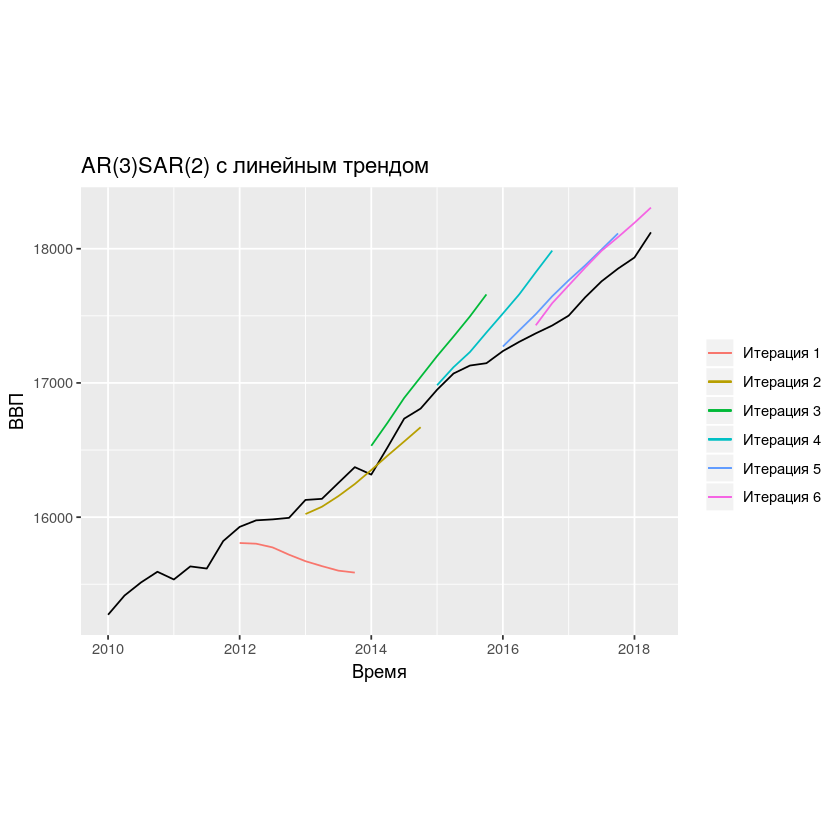

In [29]:
plot_forecasts  <-  autoplot(window(gdp_agg, start=2010))+
    xlab("Время") + ylab('ВВП') +
    ggtitle("AR(3)SAR(2) с линейным трендом") +
    guides(colour=guide_legend(title=" ")) +
    theme(aspect.ratio = 0.75)

# for (i in 0:(var_iter*var_allornot - var_shift)){
#     k  <-  k+1
#     st_year  <-  var_start_year + i/var_allornot
#     train_start  <- st_year 
#     train_end  <- st_year + 1/var_freq*(var_window)
#     test_start  <- st_year + 1/var_freq*(var_window+1) 
#     test_end  <-  st_year + 1/var_freq*(var_window+var_h)
    
#     dates  <-  (c(train_start, train_end, test_start, test_end, train_start-var_topup/var_freq, train_end-var_topup/var_freq, test_start-var_topup/var_freq)-var_start_year)*var_freq+1

    

for (i in 1:length(l)){
    if (i!=length(l)){
    plot_forecasts  <-  plot_forecasts  + 
    autolayer(msts(l[[i]][,1], seasonal.periods = var_freq, start=var_start_year + i/var_allornot+1/var_freq*(var_window+1)-1), series=paste("Итерация" , i, sep=" ") ) 
    }else{
            plot_forecasts  <-  plot_forecasts  + 
    autolayer(msts(l[[i]][,1], seasonal.periods = var_freq, start=var_start_year + i/var_allornot+1/var_freq*(var_window+1)-1-var_topup/var_freq), series=paste("Итерация" , i, sep=" ") ) 

        
    }
}

plot_forecasts


In [30]:
colMeans(df_acc)
df_mean_acc

ME       RMSE       MAPE  Iteration 
-70.993912 263.552189   1.388001  10.666667

,Квартальные,Сезонно сглаженные,Месячные
1 level,88.92257,242.1291,9146.793
3 level,96.77646,248.2335,10496.554
2 level (state),102.22984,242.5226,10507.589
2 level (type),92.26188,241.7866,9970.511
2 level (clusetered),97.38575,241.0673,10387.388


In [31]:
# df_mean_acc <- readRDS("df_mean_acc.rds")
# rownames(df_mean_acc)[2:5]  <-  c('3 level', '2 level (state)', '2 level (type)' ,'2 level (clusetered)' )

In [32]:
df_mean_acc[3,2]  <-  colMeans(df_acc)[[2]] 
df_mean_acc

,Квартальные,Сезонно сглаженные,Месячные
1 level,88.92257,242.1291,9146.793
3 level,96.77646,248.2335,10496.554
2 level (state),102.22984,263.5522,10507.589
2 level (type),92.26188,241.7866,9970.511
2 level (clusetered),97.38575,241.0673,10387.388


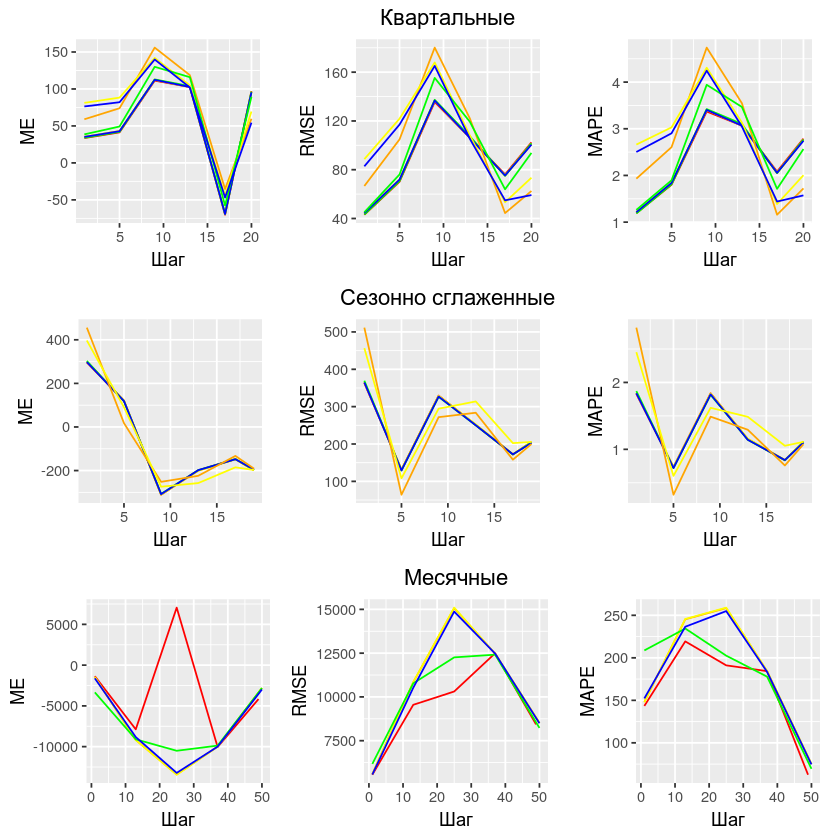

In [33]:
# Basic line plot with points

# plots_test_all <- readRDS("plots_test_not_all.rds")

var_col_test  <-  'yellow'
# var_col_train  <-  'red'

for (i in 1:3) {
    
    k = i + 3
    
    if  (i==1) {
        
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=ME), colour = var_col_test, data =  df_acc) 
    
        } else if (i==2) { 
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=RMSE), colour = var_col_test, data =  df_acc) 
        } else if (i==3)  {
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=MAPE), colour = var_col_test, data =  df_acc) 
 
    }        
    }

grid.arrange(grobs = plots_test_all, ncol = 3)

#### 2 type

In [34]:
df_eu  <-  read.csv(file="../clustering/hts_us_ind_filled_type.csv", header=TRUE, sep=",", row.names =1 )
df_eu  <-  df_eu/1000


In [35]:
# var_allornot  <- var_freq
var_allornot  <- 1
# var_shift  <-  var_topup
var_shift  <-  0

In [36]:
df_eu  <-  as.data.table(df_eu)
data  <-  df_eu
y  <-  hts(data)
s  <-  smatrix(y)
# gts_train  <- window(y, start=20, end=67)
# gts_test  <- window(y, start=68, end=75)
allts <- aggts(y)
allf <- matrix(, nrow=var_h, ncol=ncol(allts))

Since argument characters are not specified, the default labelling system is used.


In [37]:
l <- ac <- m_top  <- l_test  <-  l_top  <-  list()

df_ac  <-  data.frame(matrix(ncol = 0, nrow = 0))

k  <- 0

for (i in 0:(var_iter*var_allornot - var_shift)){
    k  <-  k+1
    st_year  <-  var_start_year + i/var_allornot
    train_start  <- st_year 
    train_end  <- st_year + 1/var_freq*(var_window)
    test_start  <- st_year + 1/var_freq*(var_window+1) 
    test_end  <-  st_year + 1/var_freq*(var_window+var_h)
    
    dates  <-  (c(train_start, train_end, test_start, test_end, train_start-var_topup/var_freq, train_end-var_topup/var_freq, test_start-var_topup/var_freq)-var_start_year)*var_freq+1
    
    train_start  <- dates[1] 
    train_end  <- dates[2]
    test_start  <- dates[3]
    test_end  <- dates[4]
    
    print(c(train_start, train_end, test_start, test_end))
    
    
    if (i == 0){
        gts_train <- window(y, end=train_end)    
    }
    else{
        if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
            gts_train <- window(y, start=dates[5], end=dates[6])
        }else{
            gts_train <- window(y, start=train_start, end=train_end)
    }}
    
    if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
        gts_test <- window(y, start=dates[7])
      
    }else{  
     gts_test <- window(y, start=test_start, end=test_end)
          
    }
    
            
    allts <- aggts(gts_train)
    
    t <- train_start:train_end
    regressors <- cbind(trend=t,quad=t^2)
    
    
    ms <-  foreach(j=1:ncol(allts)) %dopar% {
        model  <- tryCatch(        
        Arima(msts(allts[,j], seasonal.periods = var_freq), order=var_arpdq, seasonal=var_sarpdq, xreg = regressors, include.drift = var_drift, include.mean = var_constant,  method="ML"), 
            error = function(e) 
#                               {tryCatch( 
                Arima(msts(allts[,j], seasonal.periods = var_freq), order=var_arpdq, seasonal=var_sarpdq, xreg = regressors, include.drift = var_drift, include.mean = var_constant, method="CSS") #,
#                          error = function(e)              
#                             auto.arima(msts(allts[,j], seasonal.periods = var_freq))
#                          )}
                        
            )
        
    }
    
     
        
    allf <- matrix(, nrow=var_h, ncol=ncol(allts))
        
    t_f <- test_start:test_end
    regressors_f <- cbind(trend=t_f,quad=t_f^2) 
    
    
    
    for(j in 1:ncol(allts)){  
    allf[,j] <- forecast(ms[[j]], h=var_h, xreg = regressors_f)$mean
    
    
    }

    
    allf <- ts(allf)
    colnames(allf)  <-  colnames(allts)  
    g <- get_nodes(gts_train)
    y.f <- combinef(allf, nodes = g, weights = c(0,rep(1, dim(df_eu)[2])))
    forecasts_7  <- y.f[[1]]
    colnames(forecasts_7)  <- colnames(y[[1]])
    data_f5  <- rbind(gts_train[[1]], forecasts_7)
    y_f5  <- hts(data_f5)
    gts_forecasts_7 <- window(y_f5, start=dim(y_f5[[1]])[1]-var_h+1)
    this_model_list[[k]]  <- ms
    l[[k]]  <- allts(gts_forecasts_7)
    ac[[k]]  <-  accuracy.gts(gts_forecasts_7, gts_test)[, 1] 
    progress(i, progress.bar = TRUE)
    }



[1]  1 28 29 36


Since argument characters are not specified, the default labelling system is used.


          0%---------25%---------50%---------75%--------100%
Progress: [1]  5 32 33 40


Since argument characters are not specified, the default labelling system is used.


[1]  9 36 37 44


Since argument characters are not specified, the default labelling system is used.


|[1] 13 40 41 48


Since argument characters are not specified, the default labelling system is used.


|[1] 17 44 45 52


Since argument characters are not specified, the default labelling system is used.


[1] 21 48 49 56


Since argument characters are not specified, the default labelling system is used.


In [38]:
var_acc_metrics  <-  c(1,2,4)
df_acc_test  <- ac[[1]][var_acc_metrics]
for (i in ac[2:length(ac)]){
    x  <-  i[var_acc_metrics]
    df_acc_test   <-  cbind(df_acc_test, x)
}
df_acc_test  <- t(df_acc_test)
df_acc_test  <-  as.data.frame(df_acc_test)
row.names(df_acc_test)  <-  seq(1,length(ac))
df_acc  <- df_acc_test
df_acc  <-  cbind(df_acc, seq(1, length(ac)))
colnames(df_acc)[length(var_acc_metrics)+1]  <-  'Iteration'

In [39]:
df_acc$Iteration  <-  df_acc$Iteration*var_freq-(var_freq-1)
df_acc$Iteration[length(df_acc$Iteration)]  <-   df_acc$Iteration[length(df_acc$Iteration)] - var_topup

In [40]:
this_file_models_list[[3]]  <-  this_model_list


In [41]:
l[[5]][,1]

Time Series:
Start = 29 
End = 36 
Frequency = 1 
[1] 17235.64 17327.32 17458.07 17599.07 17730.79 17856.77 17970.52 18079.09

In [42]:
gdp_agg

         Qtr1     Qtr2     Qtr3     Qtr4
2005 14810.82 14901.49 15022.51 15101.40
2006 15314.55 15358.25 15361.53 15464.20
2007 15476.48 15549.12 15617.51 15731.15
2008 15625.38 15697.53 15581.97 15215.99
2009 15077.69 15056.99 15107.67 15245.91
2010 15272.78 15415.95 15513.26 15593.13
2011 15535.51 15632.94 15617.13 15821.82
2012 15927.61 15976.18 15983.30 15994.87
2013 16128.30 16136.38 16254.91 16372.60
2014 16316.98 16522.48 16733.98 16809.04
2015 16949.40 17070.24 17129.69 17147.05
2016 17237.31 17306.78 17369.38 17427.95
2017 17501.51 17637.46 17757.34 17851.87
2018 17934.57 18122.00                  

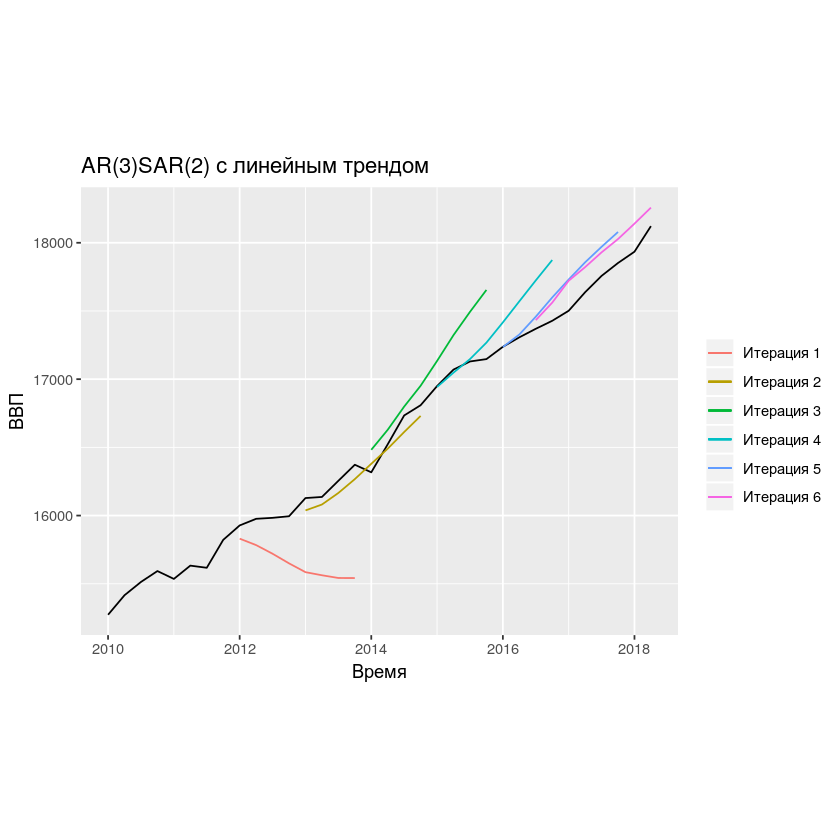

In [43]:
plot_forecasts  <-  autoplot(window(gdp_agg, start=2010))+
    xlab("Время") + ylab('ВВП') +
    ggtitle("AR(3)SAR(2) с линейным трендом") +
    guides(colour=guide_legend(title=" ")) +
    theme(aspect.ratio = 0.75)

# for (i in 0:(var_iter*var_allornot - var_shift)){
#     k  <-  k+1
#     st_year  <-  var_start_year + i/var_allornot
#     train_start  <- st_year 
#     train_end  <- st_year + 1/var_freq*(var_window)
#     test_start  <- st_year + 1/var_freq*(var_window+1) 
#     test_end  <-  st_year + 1/var_freq*(var_window+var_h)
    
#     dates  <-  (c(train_start, train_end, test_start, test_end, train_start-var_topup/var_freq, train_end-var_topup/var_freq, test_start-var_topup/var_freq)-var_start_year)*var_freq+1

    

for (i in 1:length(l)){
    if (i!=length(l)){
    plot_forecasts  <-  plot_forecasts  + 
    autolayer(msts(l[[i]][,1], seasonal.periods = var_freq, start=var_start_year + i/var_allornot+1/var_freq*(var_window+1)-1), series=paste("Итерация" , i, sep=" ") ) 
    }else{
            plot_forecasts  <-  plot_forecasts  + 
    autolayer(msts(l[[i]][,1], seasonal.periods = var_freq, start=var_start_year + i/var_allornot+1/var_freq*(var_window+1)-1-var_topup/var_freq), series=paste("Итерация" , i, sep=" ") ) 

        
    }
}

plot_forecasts


In [44]:
colMeans(df_acc)

ME       RMSE       MAPE  Iteration 
-31.844079 237.937883   1.218415  10.666667

In [45]:
# df_mean_acc <- readRDS("df_mean_acc.rds")
# rownames(df_mean_acc)[2:5]  <-  c('3 level', '2 level (state)', '2 level (type)' ,'2 level (clusetered)' )

In [46]:
df_mean_acc

,Квартальные,Сезонно сглаженные,Месячные
1 level,88.92257,242.1291,9146.793
3 level,96.77646,248.2335,10496.554
2 level (state),102.22984,263.5522,10507.589
2 level (type),92.26188,241.7866,9970.511
2 level (clusetered),97.38575,241.0673,10387.388


In [47]:
df_mean_acc[4,2]  <-  colMeans(df_acc)[[2]] 
df_mean_acc

,Квартальные,Сезонно сглаженные,Месячные
1 level,88.92257,242.1291,9146.793
3 level,96.77646,248.2335,10496.554
2 level (state),102.22984,263.5522,10507.589
2 level (type),92.26188,237.9379,9970.511
2 level (clusetered),97.38575,241.0673,10387.388


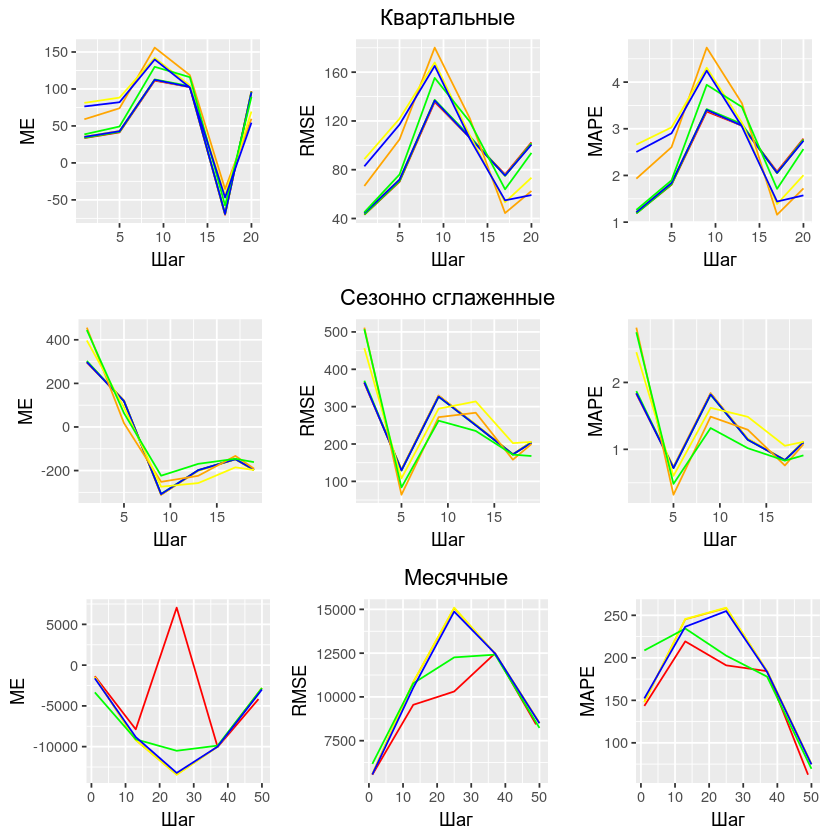

In [48]:
# Basic line plot with points

# plots_test_all <- readRDS("plots_test_not_all.rds")

var_col_test  <-  'green'
# var_col_train  <-  'red'

for (i in 1:3) {
    
    k = i + 3
    
    if  (i==1) {
        
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=ME), colour = var_col_test, data =  df_acc) 
    
        } else if (i==2) { 
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=RMSE), colour = var_col_test, data =  df_acc) 
        } else if (i==3)  {
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=MAPE), colour = var_col_test, data =  df_acc) 
 
    }        
    }

grid.arrange(grobs = plots_test_all, ncol = 3)

#### 2 clust

In [49]:
df_eu  <-  read.csv(file="../clustering/hts_us_ind_filled_clust.csv", header=TRUE, sep=",", row.names =1 )
df_eu  <-  df_eu/1000


In [50]:
# var_allornot  <- var_freq
var_allornot  <- 1
# var_shift  <-  var_topup
var_shift  <-  0

In [51]:
df_eu  <-  as.data.table(df_eu)
data  <-  df_eu
y  <-  hts(data)
s  <-  smatrix(y)
# gts_train  <- window(y, start=20, end=67)
# gts_test  <- window(y, start=68, end=75)
allts <- aggts(y)
allf <- matrix(, nrow=var_h, ncol=ncol(allts))

Since argument characters are not specified, the default labelling system is used.


In [52]:
l <- ac <- m_top  <- l_test  <-  l_top  <-  list()

df_ac  <-  data.frame(matrix(ncol = 0, nrow = 0))

k  <- 0

for (i in 0:(var_iter*var_allornot - var_shift)){
    k  <-  k+1
    st_year  <-  var_start_year + i/var_allornot
    train_start  <- st_year 
    train_end  <- st_year + 1/var_freq*(var_window)
    test_start  <- st_year + 1/var_freq*(var_window+1) 
    test_end  <-  st_year + 1/var_freq*(var_window+var_h)
    
    dates  <-  (c(train_start, train_end, test_start, test_end, train_start-var_topup/var_freq, train_end-var_topup/var_freq, test_start-var_topup/var_freq)-var_start_year)*var_freq+1
    
    train_start  <- dates[1] 
    train_end  <- dates[2]
    test_start  <- dates[3]
    test_end  <- dates[4]
    
    print(c(train_start, train_end, test_start, test_end))
    
    
    if (i == 0){
        gts_train <- window(y, end=train_end)    
    }
    else{
        if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
            gts_train <- window(y, start=dates[5], end=dates[6])
        }else{
            gts_train <- window(y, start=train_start, end=train_end)
    }}
    
    if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
        gts_test <- window(y, start=dates[7])
      
    }else{  
     gts_test <- window(y, start=test_start, end=test_end)
          
    }
    
    
            
    allts <- aggts(gts_train)
    
    t <- train_start:train_end
    regressors <- cbind(trend=t,quad=t^2)
    
    
    ms <-  foreach(j=1:ncol(allts)) %dopar% {
        model  <- tryCatch(        
        Arima(msts(allts[,j], seasonal.periods = var_freq), order=var_arpdq, seasonal=var_sarpdq,  include.drift = var_drift, include.mean = var_constant, xreg = regressors, method="ML"), 
            error = function(e) 
#                               {tryCatch( 
                Arima(msts(allts[,j], seasonal.periods = var_freq), order=var_arpdq, seasonal=var_sarpdq, include.drift = var_drift, include.mean = var_constant, xreg = regressors, method="CSS") #,
#                          error = function(e)              
#                             auto.arima(msts(allts[,j], seasonal.periods = var_freq))
#                          )}
                        
            )
        
    }
    
     
        
    allf <- matrix(, nrow=var_h, ncol=ncol(allts))
        
    t_f <- test_start:test_end
    regressors_f <- cbind(trend=t_f,quad=t_f^2) 
    
    
    
    for(j in 1:ncol(allts)){  
    allf[,j] <- forecast(ms[[j]], h=var_h, xreg = regressors_f)$mean
    
    
    }

    
    allf <- ts(allf)
    colnames(allf)  <-  colnames(allts)  
    g <- get_nodes(gts_train)
    y.f <- combinef(allf, nodes = g, weights = c(0,rep(1, dim(df_eu)[2])))
    forecasts_7  <- y.f[[1]]
    colnames(forecasts_7)  <- colnames(y[[1]])
    data_f5  <- rbind(gts_train[[1]], forecasts_7)
    y_f5  <- hts(data_f5)
    gts_forecasts_7 <- window(y_f5, start=dim(y_f5[[1]])[1]-var_h+1)
    this_model_list[[k]]  <- ms
    l[[k]]  <- allts(gts_forecasts_7)
    ac[[k]]  <-  accuracy.gts(gts_forecasts_7, gts_test)[, 1] 
    progress(i, progress.bar = TRUE)
    }



[1]  1 28 29 36


Since argument characters are not specified, the default labelling system is used.


          0%---------25%---------50%---------75%--------100%
Progress: [1]  5 32 33 40


Since argument characters are not specified, the default labelling system is used.


[1]  9 36 37 44


Since argument characters are not specified, the default labelling system is used.


|[1] 13 40 41 48


Since argument characters are not specified, the default labelling system is used.


|[1] 17 44 45 52


Since argument characters are not specified, the default labelling system is used.


[1] 21 48 49 56


Since argument characters are not specified, the default labelling system is used.


In [53]:
var_acc_metrics  <-  c(1,2,4)
df_acc_test  <- ac[[1]][var_acc_metrics]
for (i in ac[2:length(ac)]){
    x  <-  i[var_acc_metrics]
    df_acc_test   <-  cbind(df_acc_test, x)
}
df_acc_test  <- t(df_acc_test)
df_acc_test  <-  as.data.frame(df_acc_test)
row.names(df_acc_test)  <-  seq(1,length(ac))
df_acc  <- df_acc_test
df_acc  <-  cbind(df_acc, seq(1, length(ac)))
colnames(df_acc)[length(var_acc_metrics)+1]  <-  'Iteration'

In [54]:
df_acc$Iteration  <-  df_acc$Iteration*var_freq-(var_freq-1)
df_acc$Iteration[length(df_acc$Iteration)]  <-   df_acc$Iteration[length(df_acc$Iteration)] - var_topup

In [55]:
this_file_models_list[[4]]  <-  this_model_list


In [56]:
l[[5]][,1]

Time Series:
Start = 29 
End = 36 
Frequency = 1 
[1] 17245.43 17346.98 17481.48 17618.56 17752.13 17868.17 17984.66 18093.33

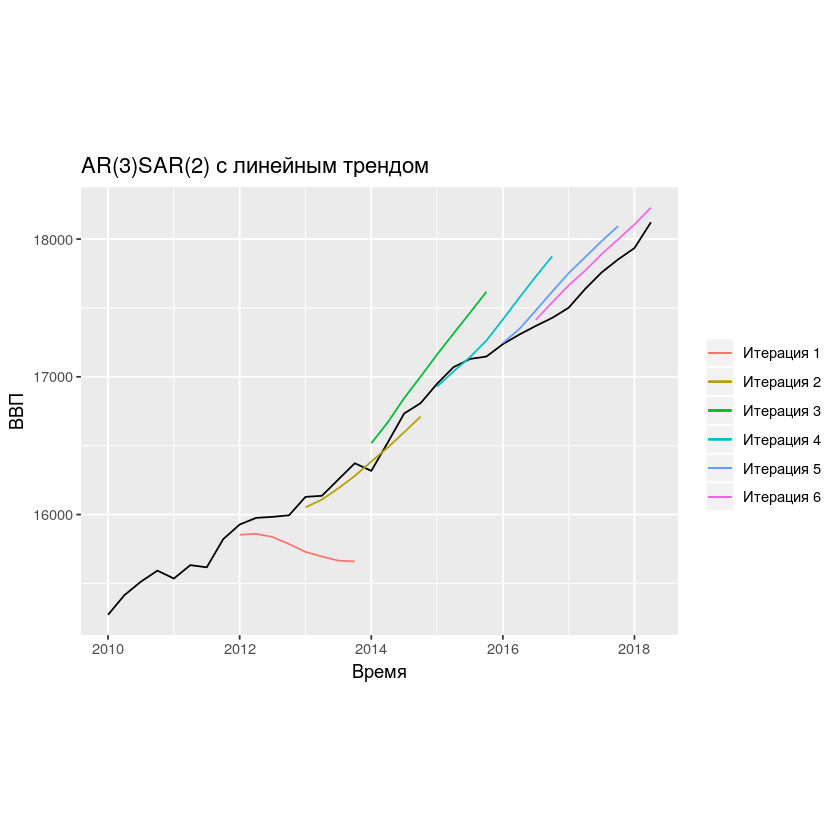

In [57]:
plot_forecasts  <-  autoplot(window(gdp_agg, start=2010))+
    xlab("Время") + ylab('ВВП') +
    ggtitle("AR(3)SAR(2) с линейным трендом") +
    guides(colour=guide_legend(title=" ")) +
    theme(aspect.ratio = 0.75)

# for (i in 0:(var_iter*var_allornot - var_shift)){
#     k  <-  k+1
#     st_year  <-  var_start_year + i/var_allornot
#     train_start  <- st_year 
#     train_end  <- st_year + 1/var_freq*(var_window)
#     test_start  <- st_year + 1/var_freq*(var_window+1) 
#     test_end  <-  st_year + 1/var_freq*(var_window+var_h)
    
#     dates  <-  (c(train_start, train_end, test_start, test_end, train_start-var_topup/var_freq, train_end-var_topup/var_freq, test_start-var_topup/var_freq)-var_start_year)*var_freq+1

    

for (i in 1:length(l)){
    if (i!=length(l)){
    plot_forecasts  <-  plot_forecasts  + 
    autolayer(msts(l[[i]][,1], seasonal.periods = var_freq, start=var_start_year + i/var_allornot+1/var_freq*(var_window+1)-1), series=paste("Итерация" , i, sep=" ") ) 
    }else{
            plot_forecasts  <-  plot_forecasts  + 
    autolayer(msts(l[[i]][,1], seasonal.periods = var_freq, start=var_start_year + i/var_allornot+1/var_freq*(var_window+1)-1-var_topup/var_freq), series=paste("Итерация" , i, sep=" ") ) 

        
    }
}

plot_forecasts


In [58]:
colMeans(df_acc)

ME       RMSE       MAPE  Iteration 
-49.954274 216.497078   1.101487  10.666667

In [59]:
# df_mean_acc <- readRDS("df_mean_acc.rds")
# rownames(df_mean_acc)[2:5]  <-  c('3 level', '2 level (state)', '2 level (type)' ,'2 level (clusetered)' )

In [60]:
df_mean_acc

,Квартальные,Сезонно сглаженные,Месячные
1 level,88.92257,242.1291,9146.793
3 level,96.77646,248.2335,10496.554
2 level (state),102.22984,263.5522,10507.589
2 level (type),92.26188,237.9379,9970.511
2 level (clusetered),97.38575,241.0673,10387.388


In [61]:
df_mean_acc[5,2]  <-  colMeans(df_acc)[[2]] 
df_mean_acc

,Квартальные,Сезонно сглаженные,Месячные
1 level,88.92257,242.1291,9146.793
3 level,96.77646,248.2335,10496.554
2 level (state),102.22984,263.5522,10507.589
2 level (type),92.26188,237.9379,9970.511
2 level (clusetered),97.38575,216.4971,10387.388


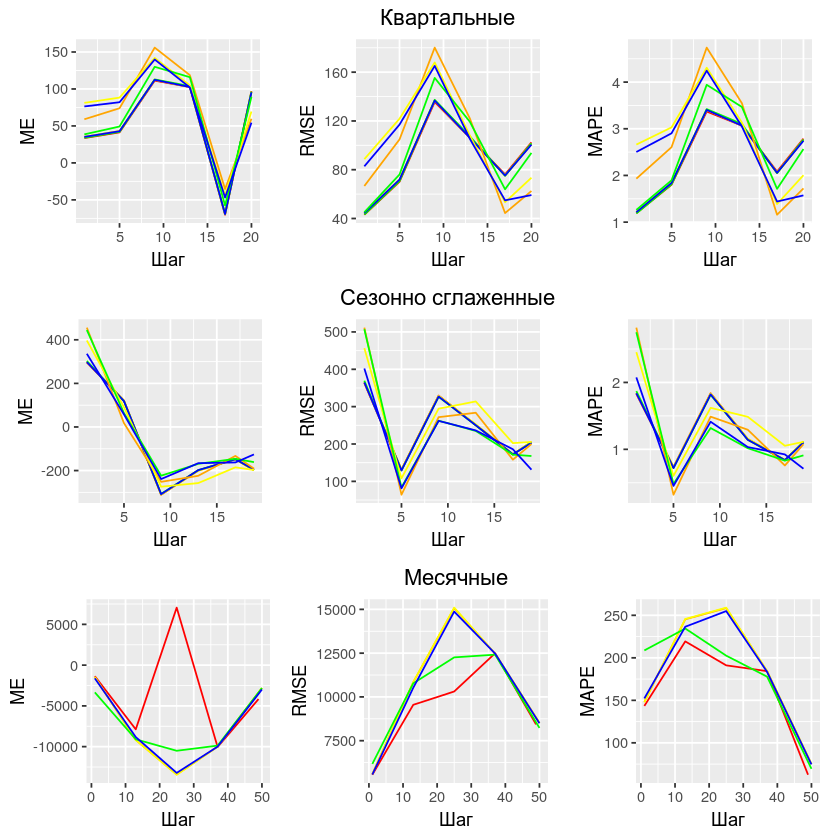

In [62]:
# Basic line plot with points

# plots_test_all <- readRDS("plots_test_not_all.rds")

var_col_test  <-  'blue'
# var_col_train  <-  'red'

for (i in 1:3) {
    
    k = i + 3
    
    if  (i==1) {
        
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=ME), colour = var_col_test, data =  df_acc) 
    
        } else if (i==2) { 
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=RMSE), colour = var_col_test, data =  df_acc) 
        } else if (i==3)  {
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=MAPE), colour = var_col_test, data =  df_acc) 
 
    }        
    }

grid.arrange(grobs = plots_test_all, ncol = 3)

In [63]:
saveRDS(df_mean_acc, "df_mean_acc_noweights.rds")
saveRDS(plots_test_all, "plots_test_not_all_noweights.rds")


In [64]:
df_mean_acc

,Квартальные,Сезонно сглаженные,Месячные
1 level,88.92257,242.1291,9146.793
3 level,96.77646,248.2335,10496.554
2 level (state),102.22984,263.5522,10507.589
2 level (type),92.26188,237.9379,9970.511
2 level (clusetered),97.38575,216.4971,10387.388


In [65]:
all_models_list <- readRDS("all_models_list.rds")
all_models_list[[2]]  <-  this_file_models_list
saveRDS(all_models_list, "all_models_list.rds")
